In [1]:
# Import modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import rv_continuous
import scienceplots

plt.style.use(['science', 'no-latex'])  
plt.rcParams['font.sans-serif'] = "cmr14"
plt.rcParams['mathtext.fontset'] = "cm" 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14

In [2]:
# Define data
data = pd.read_excel("dudu.xlsx")
data

,source_id,designation,ra,dec,l,b,ecl_lon,ecl_lat,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ra_error,dec_error,parallax_error
0,4301758223417050112,Gaia DR3 4301758223417056256,297.652131,9.864402,48.599491,-8.381066,301.972250,30.285875,0.527587,-9.093504,-4.392366,16.548437,17.033287,15.904316,0.046206,0.033813,0.054808
1,4301758227723780096,Gaia DR3 4301758227723786240,297.652626,9.865137,48.600380,-8.381127,301.972983,30.286489,0.275369,-2.969194,-6.699789,18.827599,19.275406,18.074654,0.183259,0.133162,0.208844
2,4301758983644640256,Gaia DR3 4301758983644640000,297.641774,9.862695,48.592901,-8.373033,301.960283,30.286389,1.434609,-5.143727,-2.143541,14.886640,15.435336,14.180232,0.023073,0.017048,0.028030
3,4301757506169330176,Gaia DR3 4301757506169333248,297.635007,9.864155,48.590860,-8.366513,301.953102,30.289240,2.279562,-3.142176,-6.618858,20.567920,21.084590,19.976645,1.118473,0.957378,1.335192
4,4301711494175020032,Gaia DR3 4301711494175024384,297.743264,9.857341,48.638085,-8.462638,302.072052,30.259756,-0.987790,-0.460618,-3.164507,19.970562,20.437193,19.387829,0.472674,0.352408,0.550870


In [3]:
# Compute the fractional parallax error 
data['f']=data['parallax_error']/data['parallax']
data

,source_id,designation,ra,dec,l,b,ecl_lon,ecl_lat,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ra_error,dec_error,parallax_error,f
0,4301758223417050112,Gaia DR3 4301758223417056256,297.652131,9.864402,48.599491,-8.381066,301.972250,30.285875,0.527587,-9.093504,-4.392366,16.548437,17.033287,15.904316,0.046206,0.033813,0.054808,0.103885
1,4301758227723780096,Gaia DR3 4301758227723786240,297.652626,9.865137,48.600380,-8.381127,301.972983,30.286489,0.275369,-2.969194,-6.699789,18.827599,19.275406,18.074654,0.183259,0.133162,0.208844,0.758415
2,4301758983644640256,Gaia DR3 4301758983644640000,297.641774,9.862695,48.592901,-8.373033,301.960283,30.286389,1.434609,-5.143727,-2.143541,14.886640,15.435336,14.180232,0.023073,0.017048,0.028030,0.019538
3,4301757506169330176,Gaia DR3 4301757506169333248,297.635007,9.864155,48.590860,-8.366513,301.953102,30.289240,2.279562,-3.142176,-6.618858,20.567920,21.084590,19.976645,1.118473,0.957378,1.335192,0.585723
4,4301711494175020032,Gaia DR3 4301711494175024384,297.743264,9.857341,48.638085,-8.462638,302.072052,30.259756,-0.987790,-0.460618,-3.164507,19.970562,20.437193,19.387829,0.472674,0.352408,0.550870,-0.557679


In [4]:
# Define a constant-density radial probability distribution up to rlim
def constant_density(r, rlim):
    return 3*r**2 / rlim**3

# Define an exponential-decreasing radial probability distribution with scale length rlen
def exponential_decrease(r, rlen):
    return (r**2 / (2*rlen**3)) * np.exp(-r/rlen)

# Compute the likelihood of the distance for a given star (index i) and maximum distance rmax
def likelihood(rmax, i):
    # Generate a finely spaced array of distances from 0.1 to rmax
    distance = np.linspace(0.1, rmax, 100000)      

    # Likelihood based on observed parallax and its error (converted to arcseconds)
    likelihood_a = norm.pdf(x=1/distance, scale=data['parallax_error'][i]/1000, loc=data['parallax'][i]/1000)

    # Normalize the likelihood over the distance range
    normalization, _ = integrate.quad(
        lambda t: norm.pdf(x=1/t, scale=data['parallax_error'][i]/1000, loc=data['parallax'][i]/1000), 
        a=0, b=rmax
    )
    likelihood_a /= normalization

    return distance, likelihood_a


In [5]:
# Compute the normalized likelihood as a function of distance for star index i,
# using a distance limit that depends on the fractional parallax error.
def likelihood_pdf(i):
    if (data['f'][i] < 0.1) & (data['f'][i] > 0):
        # Use a tighter distance limit for high-precision parallaxes
        limit = 2000 / abs(data['parallax'][i])
        h = likelihood(limit, i)
        distance_1 = h[0]
        likelihood_1 = h[1]
    else:
        limit = 5000 / abs(data['parallax'][i])
        h = likelihood(limit, i)
        distance_1 = h[0]
        likelihood_1 = h[1]

    return distance_1, likelihood_1


In [6]:
# Define prior probability distributions and compute normalized posterior
# 1. Uniform prior
def uniform_pdf(i):
    # Get distance array and likelihood for star i
    l = likelihood_pdf(i)
    distance = l[0]
    likelihood_d = l[1]

    # Define uniform prior over 0 to rmax
    rmax = 10000
    prior = uniform.pdf(x=distance, scale=rmax)

    # Compute posterior and normalize
    posterior = prior * likelihood_d
    posterior_norm = integrate.simps(posterior, distance)
    posterior /= posterior_norm

    # Return distance, prior, likelihood, normalized posterior, and posterior scaled by max
    return distance, prior, likelihood_d, posterior, posterior/max(posterior)

# 2. Constant volume density prior
def constantdensity_pdf(i):
    l = likelihood_pdf(i)
    distance = l[0]
    likelihood_d = l[1]
    rmax = 10000

    # Prior based on constant density in spherical volume
    prior = constant_density(distance, rmax)

    posterior = prior * likelihood_d
    posterior_norm = integrate.simps(posterior, distance)
    posterior /= posterior_norm

    return distance, prior, likelihood_d, posterior, posterior/max(posterior)

# 3. Exponentially decreasing volume density prior
def exponentialdecrease_pdf(i):
    l = likelihood_pdf(i)
    distance = l[0]
    likelihood_d = l[1]
    rlen = 1350
    rmax = max(distance)

    # Prior decreases exponentially with scale length rlen
    prior = exponential_decrease(distance, rlen)

    posterior = prior * likelihood_d
    posterior_norm = integrate.simps(posterior, distance)
    posterior /= posterior_norm

    return distance, prior, likelihood_d, posterior, posterior/max(posterior), rlen

In [7]:
# Function to estimate uncertainties from a distribution using the half-maximum method
def uncertainty(x, y):
    import pandas as pd
    df = pd.DataFrame({"x": x, "y": y})
    
    # Locate the mode of the distribution
    mode = x[np.argmax(y)]
    y_2 = 0.5 * max(y)
   
    # Compute half-maximum positions on left and right of the mode
    if mode != max(x) and mode != min(x) and y_2 > y[np.argmax(x)] and (x[np.argmax(y)]/1000) < 99:
        # Left side
        df1 = df[df["x"] < mode]
        df1_1 = df1[df1["y"] < y_2]
        id_1 = df1_1.idxmax()[0]
        x1_l = df['x'][id_1]
        x1_r = df['x'][id_1 + 1]
        y1_l = df['y'][id_1]
        y1_r = df['y'][id_1 + 1]
        half_max_l = x1_l + ((y_2 - y1_l) * (x1_r - x1_l) / (y1_r - y1_l))

        # Right side
        df2 = df[df["x"] > mode]
        df2_2 = df2[df2["y"] < y_2]
        id_2 = df2_2.idxmin()[0]
        x2_l = df['x'][id_2]
        x2_r = df['x'][id_2 + 1]
        y2_l = df['y'][id_2]
        y2_r = df['y'][id_2 + 1]
        half_max_r = x2_l + ((y_2 - y2_l) * (x2_r - x2_l) / (y2_r - y2_l))

    else:
        half_max_l = 0
        half_max_r = 0
        mode = 0

    return half_max_l, half_max_r, mode

# Function to round a number with "round half up" rule
def round_half_up(n, decimals=0):
    multi = 10 ** decimals
    return math.floor(n * multi + 0.5) / multi

In [20]:
def results(i, save):
    # Create figure with 2 rows and 3 columns of subplots
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.3)

    # Set a super title with designation, parallax, parallax error, and fractional error f
    fig.suptitle(str(data['designation'][i]) +
        "\n" r" $\varpi \ =$ " + str(round_half_up(data['parallax'][i], 4)) + 
        r" $\pm$ " + str(round_half_up(data['parallax_error'][i], 4)) + 
        r" $\mu as$" "\n" "$f=$" + str(round_half_up(data['f'][i], 3)), 
        fontsize=20, y=1.03
    )

    # -------------------------
    # Plot Uniform prior
    # -------------------------
    ud = uniform_pdf(i)
    ax[0][0].plot(ud[0]/1000, ud[2], label="Likelihood", color="darkcyan", linestyle="dashed")
    ax[0][0].plot(ud[0]/1000, ud[1], label="Prior", color="coral", linestyle="dashdot")
    ax[0][0].plot(ud[0]/1000, ud[3], label="Posterior", color="black")
    ax[0][0].set_xlim(min(ud[0]/1000), max(ud[0]/1000))
    ax[0][0].set_xlabel('Distance (kpc)', size=12)
    ax[0][0].set_ylabel('Probability', size=12)
    ax[0][0].grid()
    ax[0][0].set_title("Uniform", size=15)
    ax[0][0].legend()

    # -------------------------
    # Plot Constant Volume Density prior
    # -------------------------
    cvd = constantdensity_pdf(i)
    ax[0][1].plot(cvd[0]/1000, cvd[2], label="Likelihood", color="darkcyan", linestyle="dashed")
    ax[0][1].plot(cvd[0]/1000, cvd[1], label="Prior", color="coral", linestyle="dashdot")
    ax[0][1].plot(cvd[0]/1000, cvd[3], label="Posterior", color="black")
    ax[0][1].set_xlim(min(cvd[0]/1000), max(cvd[0]/1000))
    ax[0][1].set_xlabel('Distance (kpc)', size=12)
    ax[0][1].set_ylabel('Probability', size=12)
    ax[0][1].grid()
    ax[0][1].set_title("Constant Volume Density", size=15)
    ax[0][1].legend()

    # -------------------------
    # Plot Exponentially Decreasing Density prior
    # -------------------------
    edvd = exponentialdecrease_pdf(i)
    ax[0][2].plot(edvd[0]/1000, edvd[2], label="Likelihood", color="darkcyan", linestyle="dashed")
    ax[0][2].plot(edvd[0]/1000, edvd[1], label="Prior", color="coral", linestyle="dashdot")
    ax[0][2].plot(edvd[0]/1000, edvd[3], label="Posterior", color="black")
    
    # Adjust x-limits depending on fractional error f
    if data['f'][i] > -1:
        ax[0][2].set_xlim(min(edvd[0]/1000), max(edvd[0]/1000))
        ax[1][2].set_xlim(min(edvd[0]/1000), max(edvd[0]/1000))
    else:
        ax[0][2].set_xlim(min(edvd[0]/1000), 20)
        ax[1][2].set_xlim(min(edvd[0]/1000), 20)
                          
    ax[0][2].set_xlabel('Distance (kpc)', size=12)
    ax[0][2].set_ylabel('Probability', size=12)
    ax[0][2].grid()
    ax[0][2].set_title("Exponentially Decreasing Density", size=15)
    ax[0][2].legend()

    # Compute uncertainty for Uniform prior posterior
    sigma_1 = uncertainty(ud[0], ud[3])
    if sigma_1[0] != 0:
        ax[1][0].axvline(sigma_1[0]/1000, linestyle="dotted", alpha=0.5, label="FWHM")
        ax[1][0].axvline(sigma_1[1]/1000, linestyle="dotted", alpha=0.5)
        ax[1][0].axvline(sigma_1[2]/1000, linestyle="dashed", alpha=0.5, color="red", label="Mode")
        dist_1 = sigma_1[2]/1000
        plus_1 = (sigma_1[1]-sigma_1[2])/1000
        minus_1 = (sigma_1[2]-sigma_1[0])/1000
        ax[1][0].set_title(r"d = ${:.4f}^{{+{:.4f}}}_{{-{:.4f}}}$ kpc".format(dist_1, plus_1, minus_1), size=16, y=1.02)
    ax[1][0].plot(ud[0]/1000, ud[3], label="Posterior", color="black")
    ax[1][0].set_xlabel('Distance (kpc)', size=12)
    ax[1][0].set_ylabel('Probability', size=12)
    ax[1][0].grid()
    ax[1][0].legend()

    # Compute uncertainty for Constant Volume Density posterior
    sigma_2 = uncertainty(cvd[0], cvd[3])
    if sigma_2[0] != 0:
        ax[1][1].axvline(sigma_2[0]/1000, linestyle="dotted", alpha=0.5, label="FWHM")
        ax[1][1].axvline(sigma_2[1]/1000, linestyle="dotted", alpha=0.5)
        ax[1][1].axvline(sigma_2[2]/1000, linestyle="dashed", alpha=0.5, color="red", label="Mode")
        dist_2 = sigma_2[2]/1000
        plus_2 = (sigma_2[1]-sigma_2[2])/1000
        minus_2 = (sigma_2[2]-sigma_2[0])/1000
        ax[1][1].set_title(r"d = ${:.4f}^{{+{:.4f}}}_{{-{:.4f}}}$ kpc".format(dist_2, plus_2, minus_2), size=16, y=1.02)
    ax[1][1].plot(cvd[0]/1000, cvd[3], label="Posterior", color="black")
    ax[1][1].set_xlabel('Distance (kpc)', size=12)
    ax[1][1].set_ylabel('Probability', size=12)
    ax[1][1].grid()
    ax[1][1].legend()

    # Compute uncertainty for Exponentially Decreasing Density posterior
    sigma_3 = uncertainty(edvd[0], edvd[3])
    if sigma_3[0] != 0:
        ax[1][2].axvline(sigma_3[0]/1000, linestyle="dotted", alpha=0.5, label="FWHM")
        ax[1][2].axvline(sigma_3[1]/1000, linestyle="dotted", alpha=0.5)
        ax[1][2].axvline(sigma_3[2]/1000, linestyle="dashed", alpha=0.5, color="red", label="Mode")
        dist_3 = sigma_3[2]/1000
        plus_3 = (sigma_3[1]-sigma_3[2])/1000
        minus_3 = (sigma_3[2]-sigma_3[0])/1000
        ax[1][2].set_title(r"d = ${:.4f}^{{+{:.4f}}}_{{-{:.4f}}}$ kpc".format(dist_3, plus_3, minus_3), size=16, y=1.02)
    ax[1][2].plot(edvd[0]/1000, edvd[3], label="Posterior", color="black")
    ax[1][2].set_xlabel('Distance (kpc)', size=12)
    ax[1][2].set_ylabel('Probability', size=12)
    ax[1][2].grid()
    ax[1][2].legend()

    # Save figure if requested
    if save == "yes":
       fig.savefig(str(i+1) + " " + str(data['designation'][i]), bbox_inches='tight')

    # Display the figure
    plt.show()

In [21]:
# Initialize lists to store results
dist_1, dist_2, dist_3 = [], [], []       # Modes for Uniform, Constant Volume, and Exponentially Decreasing priors
plus_1, plus_2, plus_3 = [], [], []       # Upper uncertainties
minus_1, minus_2, minus_3 = [], [], []   # Lower uncertainties
obj = []                                  # Object index

# Loop through all objects in the dataset
for i in range(len(data)):
    # Compute PDFs for the three priors
    ud = uniform_pdf(i)
    cvd = constantdensity_pdf(i)
    edvd = exponentialdecrease_pdf(i)
    
    # Compute uncertainties for each posterior
    sigma_1 = uncertainty(ud[0], ud[3])
    sigma_2 = uncertainty(cvd[0], cvd[3])
    sigma_3 = uncertainty(edvd[0], edvd[3])
    
    # Uniform prior: store mode and errors
    if sigma_1[0] != 0:
        dist_1.append(sigma_1[2] / 1000)                     # Mode in kpc
        plus_1.append((sigma_1[1] - sigma_1[2]) / 1000)     # Upper error
        minus_1.append((sigma_1[2] - sigma_1[0]) / 1000)    # Lower error
    else:
        dist_1.extend([0])
        plus_1.extend([0])
        minus_1.extend([0])
        
    # Constant volume density prior: store mode and errors
    if sigma_2[0] != 0:
        dist_2.append(sigma_2[2] / 1000)
        plus_2.append((sigma_2[1] - sigma_2[2]) / 1000)
        minus_2.append((sigma_2[2] - sigma_2[0]) / 1000)
    else:
        dist_2.extend([0])
        plus_2.extend([0])
        minus_2.extend([0])

    # Exponentially decreasing prior: store mode and errors
    if sigma_3[0] != 0:
        dist_3.append(sigma_3[2] / 1000)
        plus_3.append((sigma_3[1] - sigma_3[2]) / 1000)
        minus_3.append((sigma_3[2] - sigma_3[0]) / 1000)
    else:
        dist_3.extend([0])
        plus_3.extend([0])
        minus_3.extend([0])

    # Store object index
    obj.append(i + 1)

# Create a summary DataFrame with distances and uncertainties
dataprint = pd.DataFrame({
    "object": obj,
    "distance_ud": dist_1,
    "distance_cvd": dist_2,
    "distance_edvd": dist_3,
    "sig+_ud": plus_1,
    "sig+_cvd": plus_2,
    "sig+_edvd": plus_3,
    "sig-_ud": minus_1,
    "sig-_cvd": minus_2,
    "sig-_edvd": minus_3
})

# Display the summary table
print(dataprint)

C:\Users\USER\AppData\Local\Temp\ipykernel_8968\893115733.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior_norm = integrate.simps(posterior, distance)
C:\Users\USER\AppData\Local\Temp\ipykernel_8968\893115733.py:22: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior_norm = integrate.simps(posterior, distance)
C:\Users\USER\AppData\Local\Temp\ipykernel_8968\893115733.py:36: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior_norm = integrate.simps(posterior, distance)
C:\Users\USER\AppData\Local\Temp\ipykernel_8968\403984334.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

   object  distance_ud  distance_cvd  distance_edvd   sig+_ud  sig+_cvd  \
0       1     1.895425      1.938166       1.907555  0.264144  0.281099   
1       2     3.631420      0.000000       3.132996       inf  0.000000   
2       3     0.697055      0.697585       0.697445  0.016412  0.016447   
3       4     0.438677      0.000000       0.000000  0.974762  0.000000   
4       5     0.000000      0.000000       0.000000  0.000000  0.000000   

   sig+_edvd   sig-_ud  sig-_cvd  sig-_edvd  
0   0.266095  0.206576  0.217463   0.208383  
1   2.337937  1.713009  0.000000   1.181110  
2   0.016439  0.015676  0.015702   0.015692  
3   0.000000  0.179047  0.000000   0.000000  
4   0.000000  0.000000  0.000000   0.000000  


In [22]:
dataprint

,object,distance_ud,distance_cvd,distance_edvd,sig+_ud,sig+_cvd,sig+_edvd,sig-_ud,sig-_cvd,sig-_edvd
0,1,1.895425,1.938166,1.907555,0.264144,0.281099,0.266095,0.206576,0.217463,0.208383
1,2,3.631420,0.000000,3.132996,inf,0.000000,2.337937,1.713009,0.000000,1.181110
2,3,0.697055,0.697585,0.697445,0.016412,0.016447,0.016439,0.015676,0.015702,0.015692
3,4,0.438677,0.000000,0.000000,0.974762,0.000000,0.000000,0.179047,0.000000,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_8968\893115733.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior_norm = integrate.simps(posterior, distance)
C:\Users\USER\AppData\Local\Temp\ipykernel_8968\893115733.py:22: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior_norm = integrate.simps(posterior, distance)
C:\Users\USER\AppData\Local\Temp\ipykernel_8968\893115733.py:36: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  posterior_norm = integrate.simps(posterior, distance)
C:\Users\USER\AppData\Local\Temp\ipykernel_8968\403984334.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

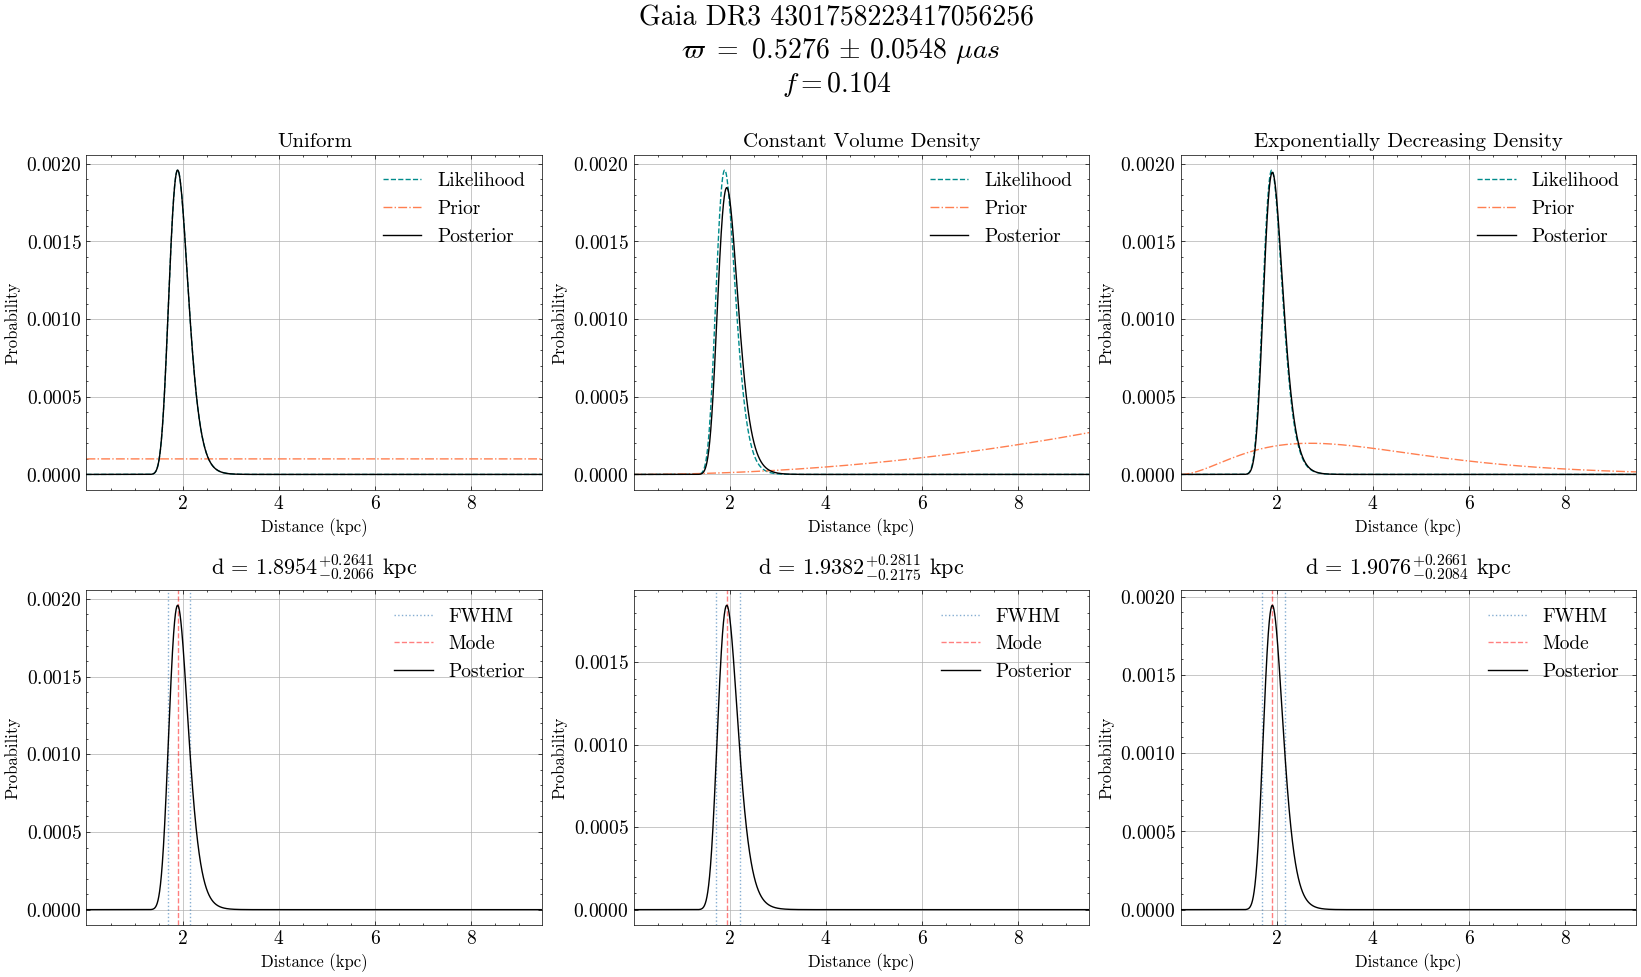

C:\Users\USER\AppData\Local\Temp\ipykernel_8968\403984334.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  half_max_r = x2_l + ((y_2-y2_l)*(x2_r-x2_l)/(y2_r-y2_l))


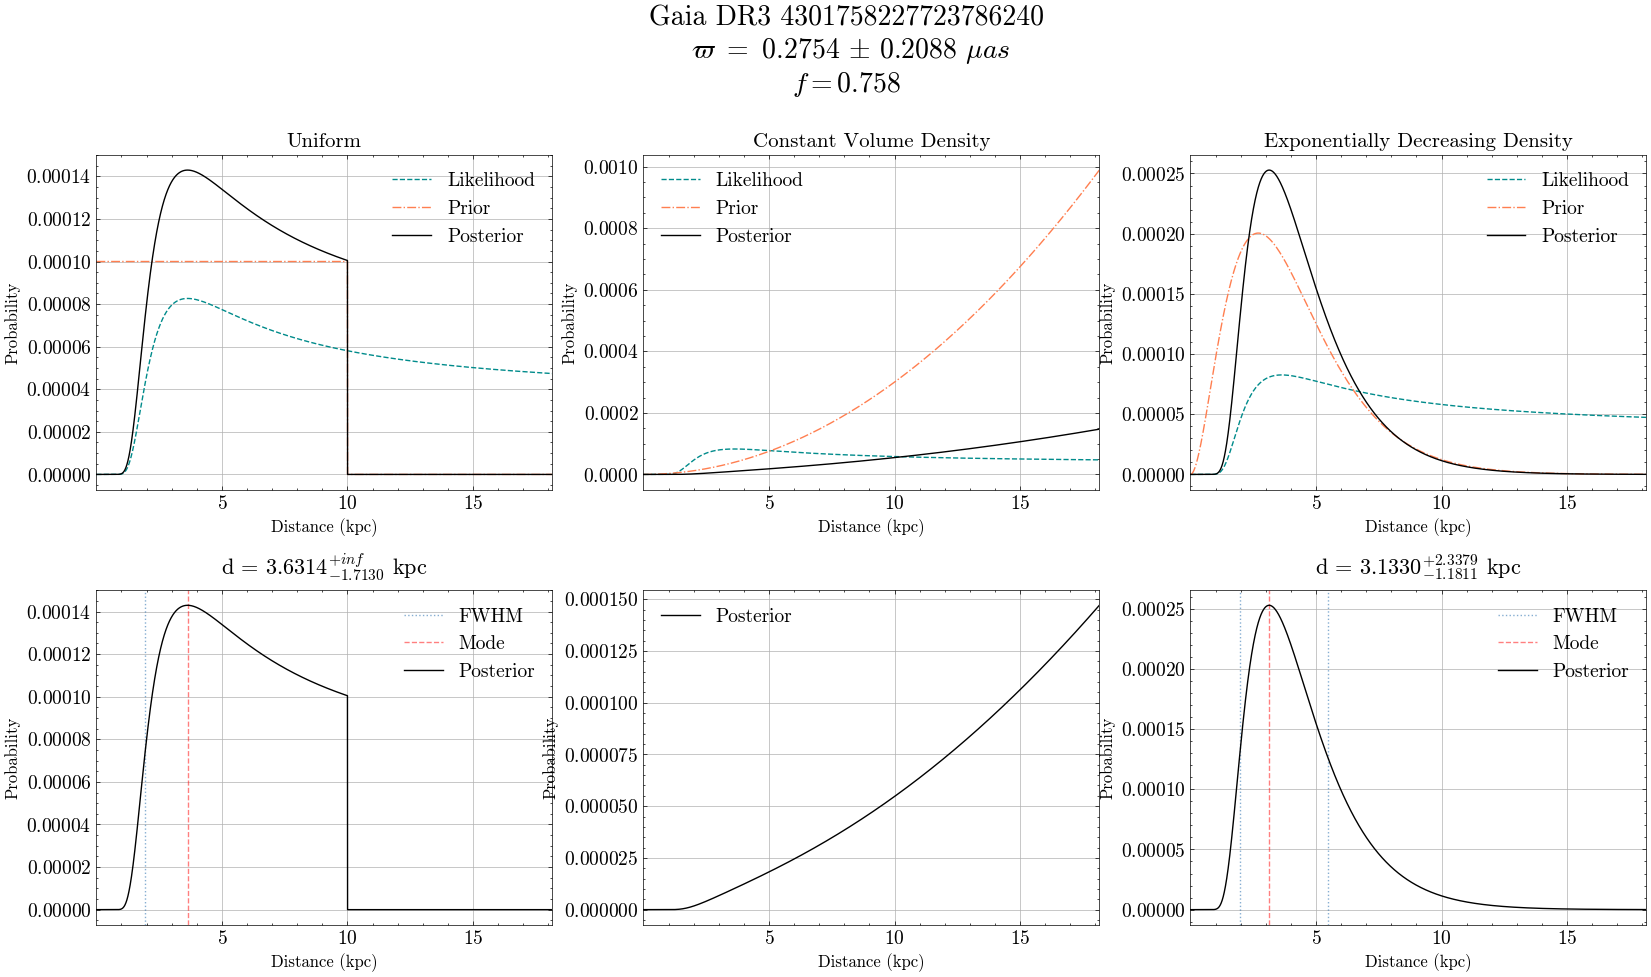

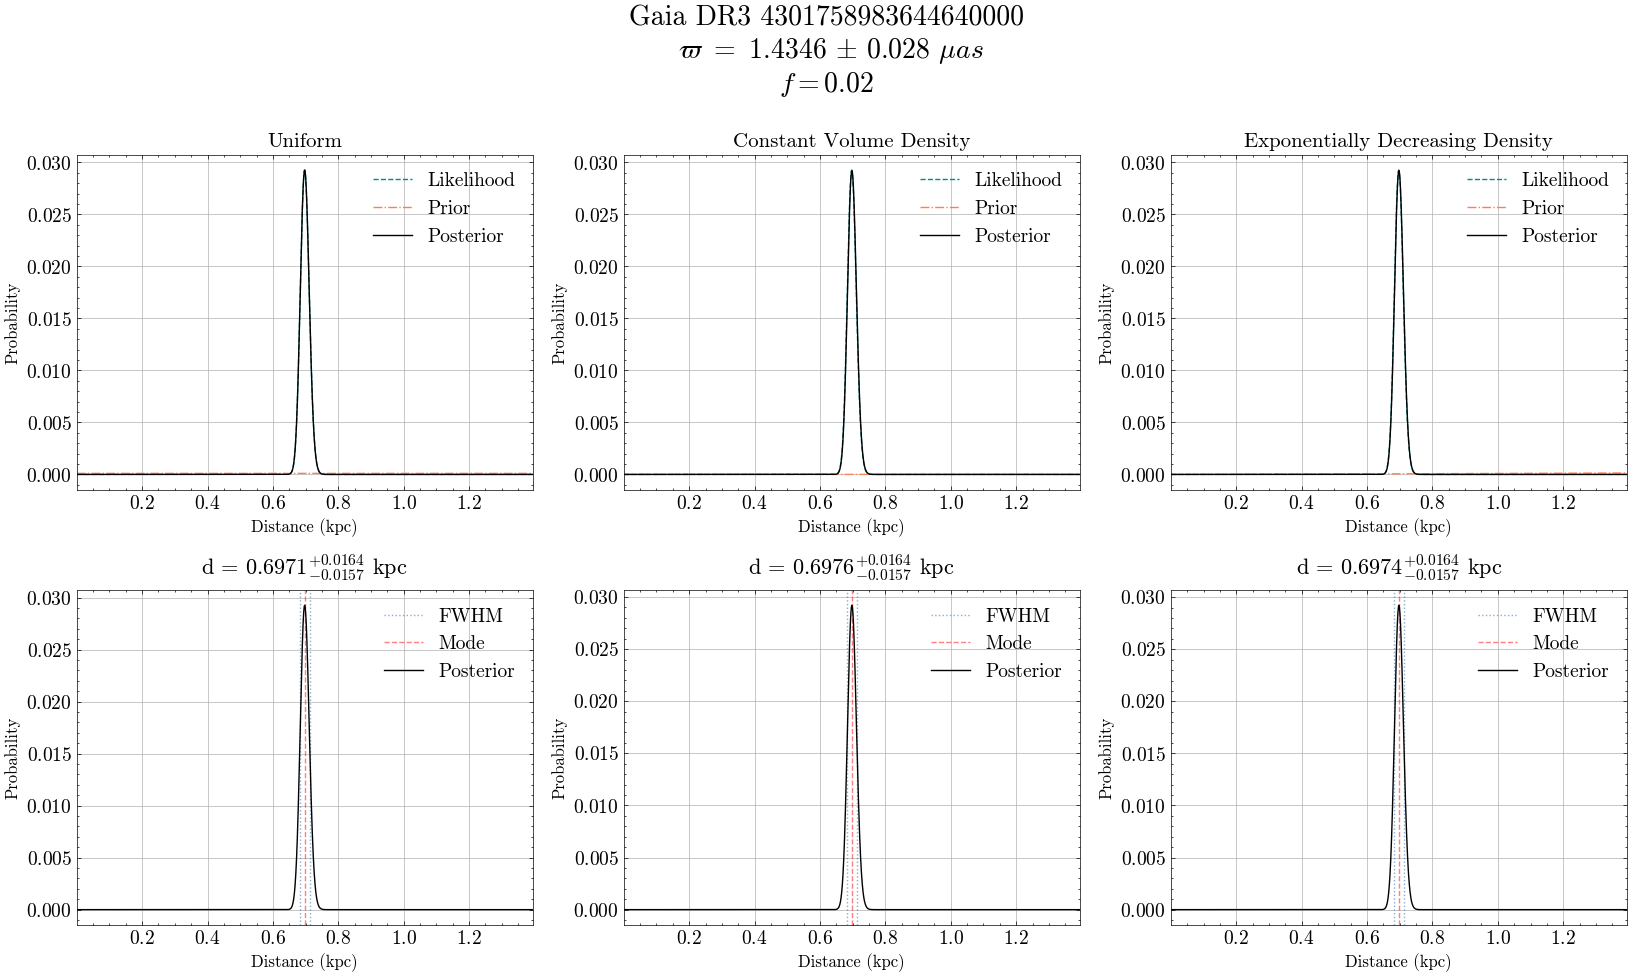

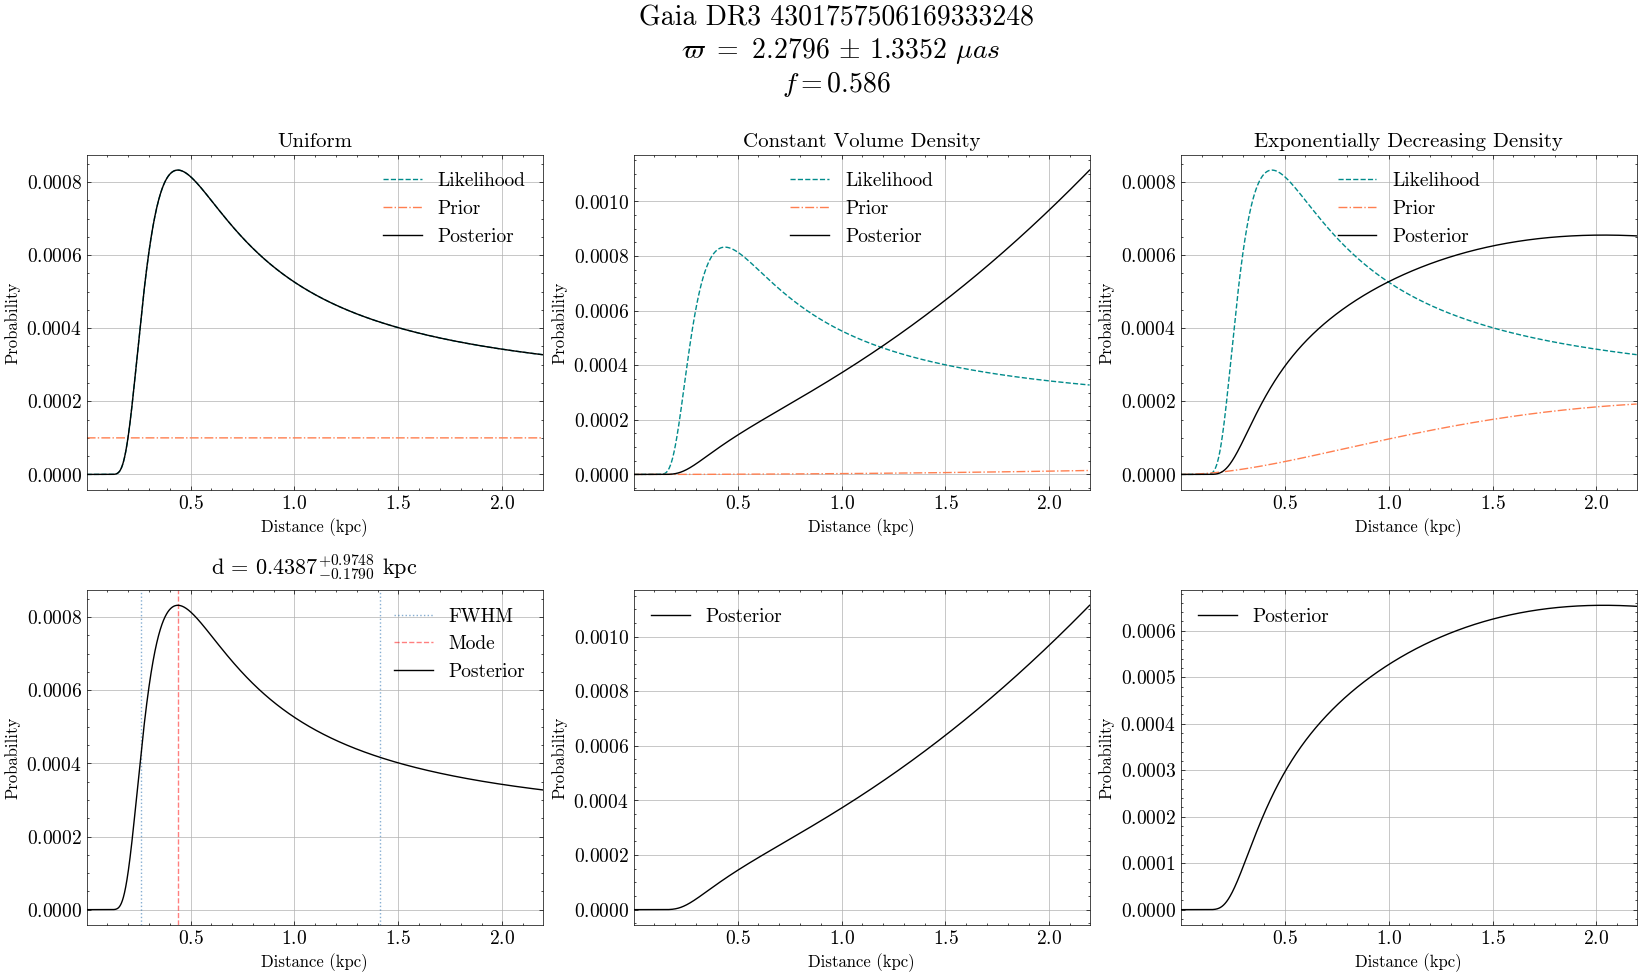

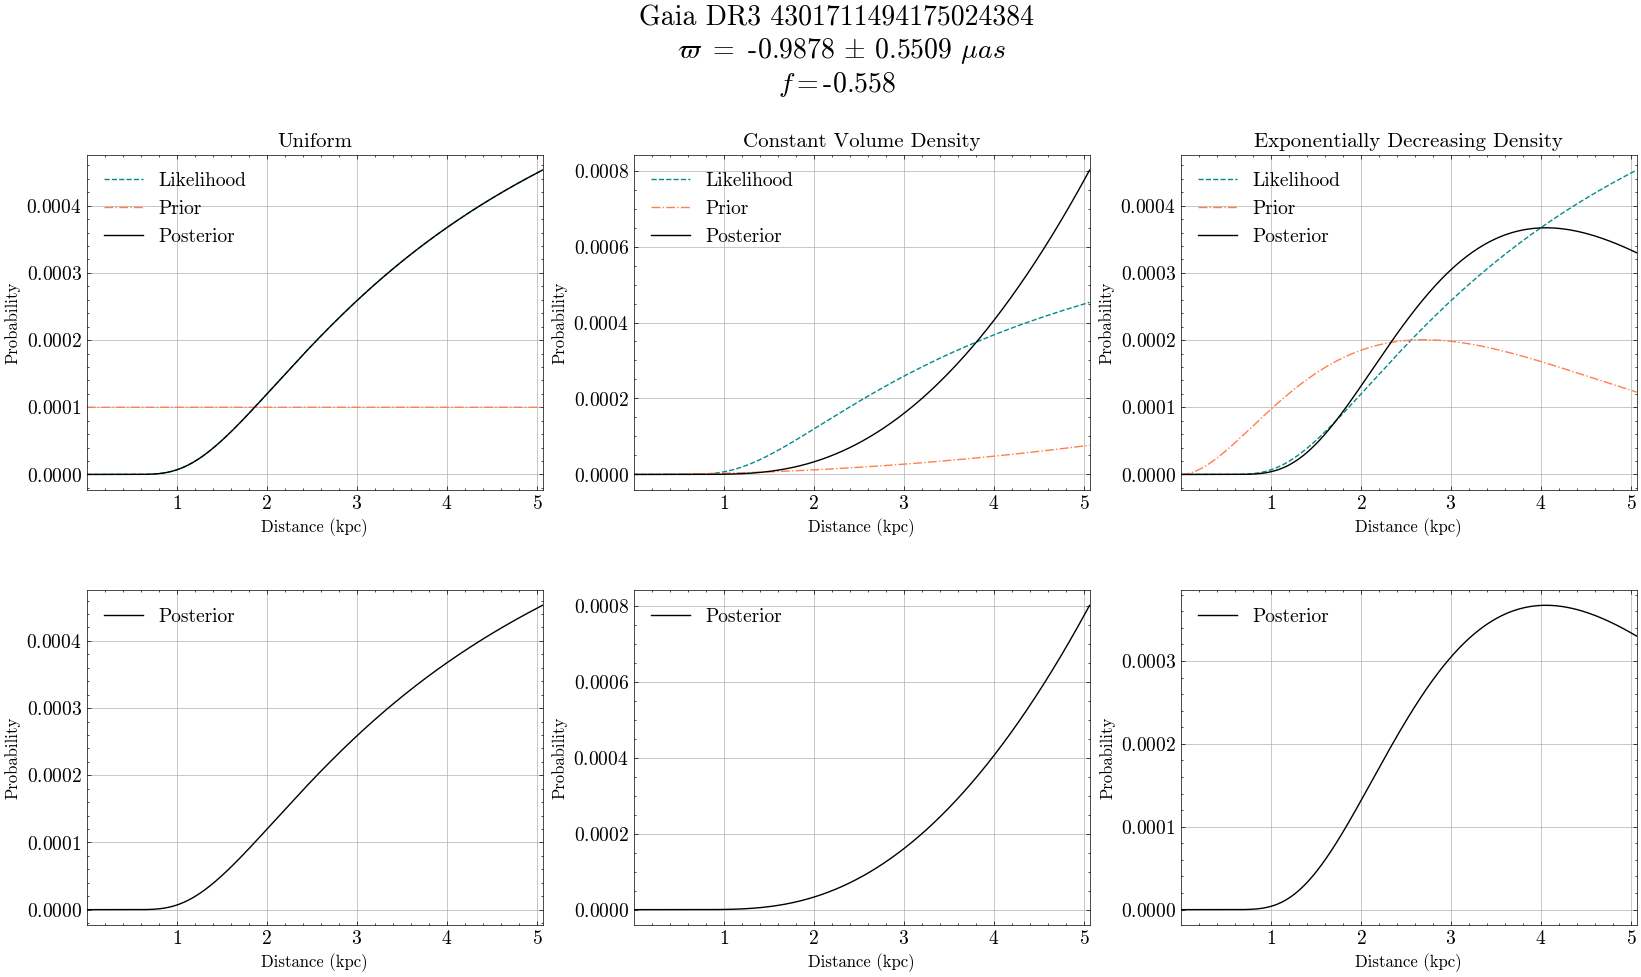

In [23]:
# Loop through all objects and generate plots
for i in range (len(data)) :
    results(i,"yes")
